In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster

# Preprocessing

In [43]:
# Predefined stuff

n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
num_clusters = 2

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [45]:
fashion_mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3204,))  
])

fashion_mnist_train_loader = DataLoader(
    datasets.FashionMNIST('/files/', train=True, download=True, transform=fashion_mnist_transform),
    batch_size=batch_size_train, shuffle=True
)

fashion_mnist_test_loader = DataLoader(
    datasets.FashionMNIST('/files/', train=False, download=True, transform=fashion_mnist_transform),
    batch_size=batch_size_test, shuffle=True
)

In [47]:
train_loader_pca = copy.copy(fashion_mnist_train_loader)
test_loader_pca = copy.copy(fashion_mnist_test_loader)

train_loader_auto = copy.copy(fashion_mnist_train_loader)
test_loader_auto = copy.copy(fashion_mnist_test_loader)

In [49]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# Pca

In [51]:
train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.2860) / 0.3204

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)

# Autoencoder

In [52]:
# Autoencoder
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.6598843336105347
Epoch [2/5], Loss: 0.6293150186538696
Epoch [3/5], Loss: 0.6253346800804138
Epoch [4/5], Loss: 0.5940108895301819
Epoch [5/5], Loss: 0.6230719089508057


In [53]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Experiment

In [71]:
numberOfPartitions = [4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [73]:
trainingset = fashion_mnist_train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()

In [75]:
for partitions_number in numberOfPartitions:
    print(f"Running experiment with {partitions_number} partitions...")

    partitioned_data_classic = partition.balanced_dirichlet_partition(trainingset, partitions_number=partitions_number, alpha=0.5)

    classic_client_loaders = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]

    num_clients = partitions_number
    local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]

  # Classic strong
    optimizer = optim.SGD(trial_model_strong.parameters(), lr=learning_rate,
                          momentum=momentum)
    
    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train_fashion(epoch, trial_model_strong, fashion_mnist_train_loader, optimizer, log_interval, train_losses, train_counter)
    


    test_losses_classic_strong = []
    test_fashion(trial_model_strong,fashion_mnist_train_loader,test_losses_classic_strong)

    rounds_classic = 4
    
    for round_idx in range(rounds_classic):
        
        print(f"Round {round_idx + 1}/{rounds_classic}")
    
        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic_strong):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
    
        global_weights_classic = federated_averaging(local_weights_classic)
    
    
        distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
    
        distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
        test_losses = []
        test_fashion(global_model_classic_strong,fashion_mnist_test_loader,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in fashion_mnist_test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(fashion_mnist_test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if partitions_number not in results["classic"]:
            results["classic"][partitions_number] = {"losses": [], "accuracy": []}

        results["classic"][partitions_number]["losses"].extend(test_losses)
        results["classic"][partitions_number]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster
    cluster = cluster.Cluster(num_clusters=4)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic_strong[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
    
        global_weights_classic = federated_averaging(local_weights_classic)
    
    
        distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
    
        distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
        test_losses = []
        test_fashion(global_model_classic_strong,fashion_mnist_test_loader,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in fashion_mnist_test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(fashion_mnist_test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if partitions_number not in clusteredResults["classic"]:
            clusteredResults["classic"][partitions_number] = {"losses": [], "accuracy": []}

        clusteredResults["classic"][partitions_number]["losses"].extend(test_losses)
        clusteredResults["classic"][partitions_number]["accuracy"].extend(test_accuracies_classic)

Running experiment with 4 partitions...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291763
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.188995
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.042720
Train Epoch: 1 [3000/60000 (5%)]	Loss: 1.865229
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.641536
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.527857
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.497014
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.276385
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.261366
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.204960
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.018607
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.047656
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.982675
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.893204
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.923746
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.966124
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.793890
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.920538
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.740007
Train Epoch: 1 [19000/60000 (

In [77]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {4: {'losses': [0.6815479064941407, 0.49938775939941404, 0.46115848693847655, 0.4383513153076172], 'accuracy': [10.29, 10.05, 10.41, 10.14]}, 6: {'losses': [0.382756201171875, 0.38323160400390627, 0.3741429901123047, 0.36963440551757815], 'accuracy': [10.28, 10.22, 10.08, 10.48]}, 8: {'losses': [0.36661693725585937, 0.3617134796142578, 0.3648541442871094, 0.3626453094482422], 'accuracy': [10.42, 10.1, 10.52, 10.87]}, 10: {'losses': [0.3590808044433594, 0.3577126373291016, 0.35142200622558595, 0.3532148468017578], 'accuracy': [10.6, 9.53, 10.48, 9.72]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {4: {'losses': [0.43703709716796874, 0.4280464233398438, 0.41145969848632813, 0.42101661376953126], 'accuracy': [10.17, 9.97, 10.26, 9.91]}, 6: {'losses': [0.3982194122314453, 0.395793017578125, 0.38184085693359376, 0.4105090576171875], 'accuracy': [9.9, 10.49, 10.04, 10.6]}, 8: {'losses': [0.40630611267089844, 0.4301157226562

## PCA

In [88]:
trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()

In [96]:
for partitions_number in numberOfPartitions:
    print(f"Running experiment with {partitions_number} partitions...")

    partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=partitions_number, alpha=0.5)
    pca_client_loaders = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca.values()
    ]

    num_clients = partitions_number
    local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

  # Pca strong
    optimizer = optim.SGD(trial_model_pca_strong.parameters(), lr=learning_rate,
                      momentum=momentum)
    
    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train_fashion(epoch, trial_model_pca_strong, train_loader_reduced_pca, optimizer, log_interval, train_losses, train_counter)
    

    
    test_losses_pca_strong = []
    test_fashion(trial_model_pca_strong,train_loader_reduced_pca,test_losses_pca_strong)
    
    rounds_pca = 4
    for round_idx in range(rounds_pca):
        
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca_strong):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
    
        global_weights_pca = federated_averaging(local_weights_pca)
    
        distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
        test_losses = []
        test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
    
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_classic.append(accuracy)
    
        # Save results for non-clustered classic
        if partitions_number not in results["pca"]:
            results["pca"][partitions_number] = {"losses": [], "accuracy": []}
    
        results["pca"][partitions_number]["losses"].extend(test_losses)
        results["pca"][partitions_number]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster
    cluster = cluster.Cluster(num_clusters=4)
    
    targets = trainingset_pca.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca_strong[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
    
        global_weights_pca = federated_averaging(local_weights_pca)
    
        distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
        test_losses = []
        test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
    
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if partitions_number not in clusteredResults["pca"]:
            clusteredResults["pca"][partitions_number] = {"losses": [], "accuracy": []}

        clusteredResults["pca"][partitions_number]["losses"].extend(test_losses)
        clusteredResults["pca"][partitions_number]["accuracy"].extend(test_accuracies_classic)

Running experiment with 4 partitions...
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.318449
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.379597
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.343822
Train Epoch: 1 [3000/60000 (5%)]	Loss: 0.312408
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.246673
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.242567
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.230922
Train Epoch: 1 [7000/60000 (12%)]	Loss: 0.353246
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.177990
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.160976
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.305976
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.407932
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.288919
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.294784
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.182461
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.275527
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.336187
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.188078
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.257024
Train Epoch: 1 [19000/60000 (

In [98]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {4: {'losses': [0.6815479064941407, 0.49938775939941404, 0.46115848693847655, 0.4383513153076172], 'accuracy': [10.29, 10.05, 10.41, 10.14]}, 6: {'losses': [0.382756201171875, 0.38323160400390627, 0.3741429901123047, 0.36963440551757815], 'accuracy': [10.28, 10.22, 10.08, 10.48]}, 8: {'losses': [0.36661693725585937, 0.3617134796142578, 0.3648541442871094, 0.3626453094482422], 'accuracy': [10.42, 10.1, 10.52, 10.87]}, 10: {'losses': [0.3590808044433594, 0.3577126373291016, 0.35142200622558595, 0.3532148468017578], 'accuracy': [10.6, 9.53, 10.48, 9.72]}}, 'pca': {4: {'losses': [1.1178964111328125, 0.9523929016113282, 0.8969520141601562, 0.851038330078125], 'accuracy': [9.98, 10.22, 9.72, 10.25]}, 6: {'losses': [0.7265787658691406, 0.7113021057128907, 0.7031130065917969, 0.6795821533203125], 'accuracy': [10.22, 10.22, 9.68, 9.8]}, 8: {'losses': [0.6413265014648437, 0.6276532104492187, 0.6225778503417969, 0.6192710388183593], 'accuracy': [10.47, 1

## Autoencoder

In [101]:
# Autoencoder
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()

In [116]:
for partitions_number in numberOfPartitions:
    print(f"Running experiment with {partitions_number} partitions...")
    
    partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=partitions_number, alpha=0.5)
    auto_client_loaders = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]
    
    num_clients = partitions_number
    local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]
    
    optimizer = optim.SGD(trial_model_auto_strong.parameters(), lr=learning_rate, momentum=momentum)
    
    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train_fashion(epoch, trial_model_auto_strong, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)
    
    test_losses_auto_strong = []
    test_fashion(trial_model_auto_strong, reduced_train_loader_auto, test_losses_auto_strong)

    rounds_auto = 4
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)
        
        # Save results for non-clustered classic
        if partitions_number not in results["autoencoder"]:
            results["autoencoder"][partitions_number] = {"losses": [], "accuracy": []}
        
        results["autoencoder"][partitions_number]["losses"].extend(test_losses)
        results["autoencoder"][partitions_number]["accuracy"].extend(test_accuracies_classic)

    ######################
    # Clustering process
    import cluster
    cluster = cluster.Cluster(num_clusters=4)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    
    partitioned_data_auto_clustered = clustered_data
    
    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]
    
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)
        
        # Save results for clustered classic
        if partitions_number not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][partitions_number] = {"losses": [], "accuracy": []}
        
        clusteredResults["autoencoder"][partitions_number]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][partitions_number]["accuracy"].extend(test_accuracies_classic)

Running experiment with 4 partitions...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305623
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.285260
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.243470
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.215178
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.189984
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.149446
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.093956
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.045938
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.963553
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.930868
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.807138
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.812732
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.700588
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.644588
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.510034
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.431245
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.373331
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.308747
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.205835
Train Epoch: 1 [19000/60000 (

In [118]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {4: {'losses': [0.6815479064941407, 0.49938775939941404, 0.46115848693847655, 0.4383513153076172], 'accuracy': [10.29, 10.05, 10.41, 10.14]}, 6: {'losses': [0.382756201171875, 0.38323160400390627, 0.3741429901123047, 0.36963440551757815], 'accuracy': [10.28, 10.22, 10.08, 10.48]}, 8: {'losses': [0.36661693725585937, 0.3617134796142578, 0.3648541442871094, 0.3626453094482422], 'accuracy': [10.42, 10.1, 10.52, 10.87]}, 10: {'losses': [0.3590808044433594, 0.3577126373291016, 0.35142200622558595, 0.3532148468017578], 'accuracy': [10.6, 9.53, 10.48, 9.72]}}, 'pca': {4: {'losses': [1.1178964111328125, 0.9523929016113282, 0.8969520141601562, 0.851038330078125], 'accuracy': [9.98, 10.22, 9.72, 10.25]}, 6: {'losses': [0.7265787658691406, 0.7113021057128907, 0.7031130065917969, 0.6795821533203125], 'accuracy': [10.22, 10.22, 9.68, 9.8]}, 8: {'losses': [0.6413265014648437, 0.6276532104492187, 0.6225778503417969, 0.6192710388183593], 'accuracy': [10.47, 1

# Plot

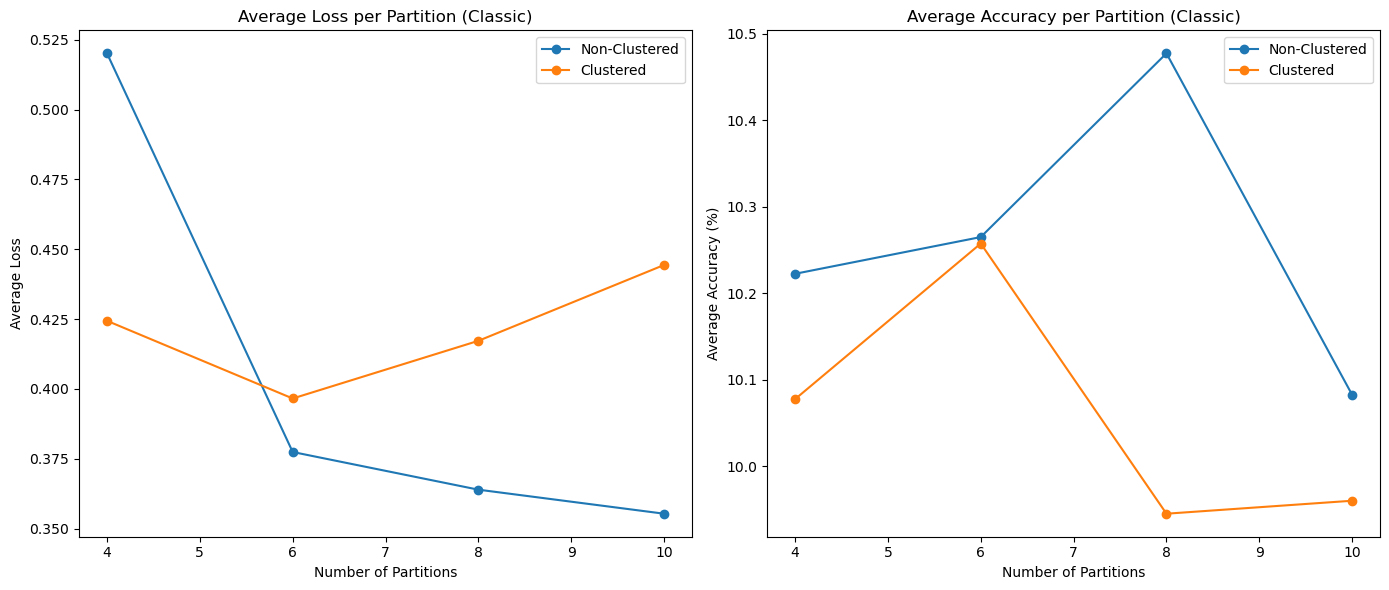

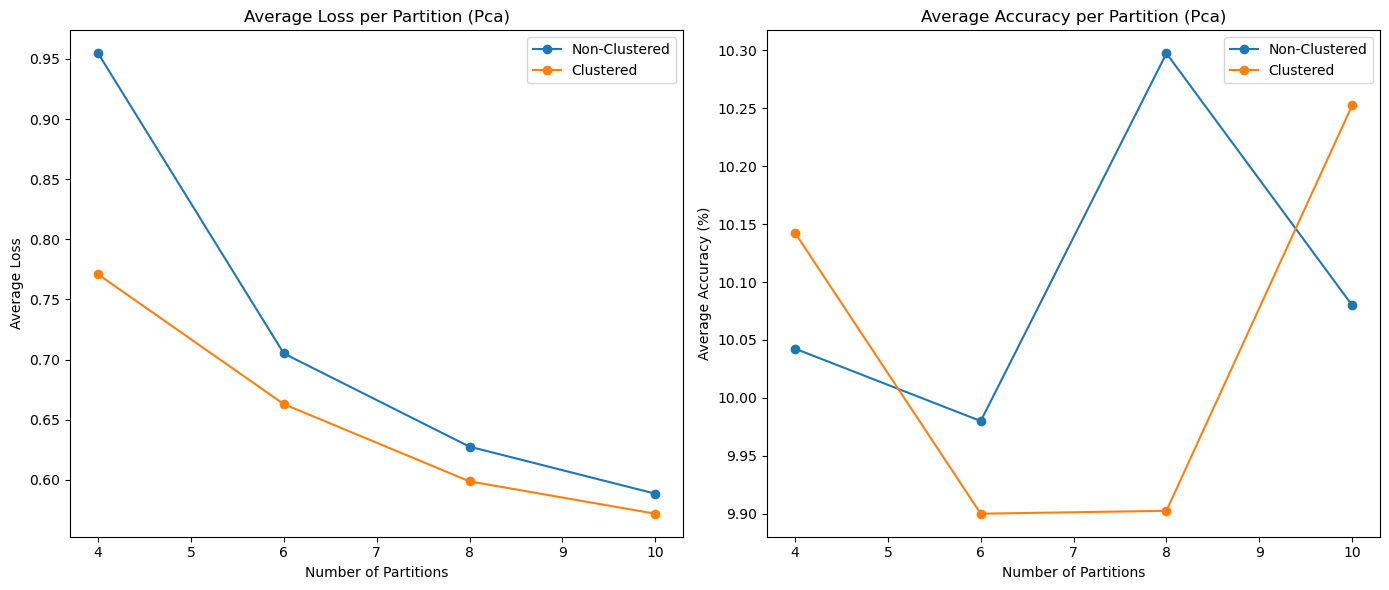

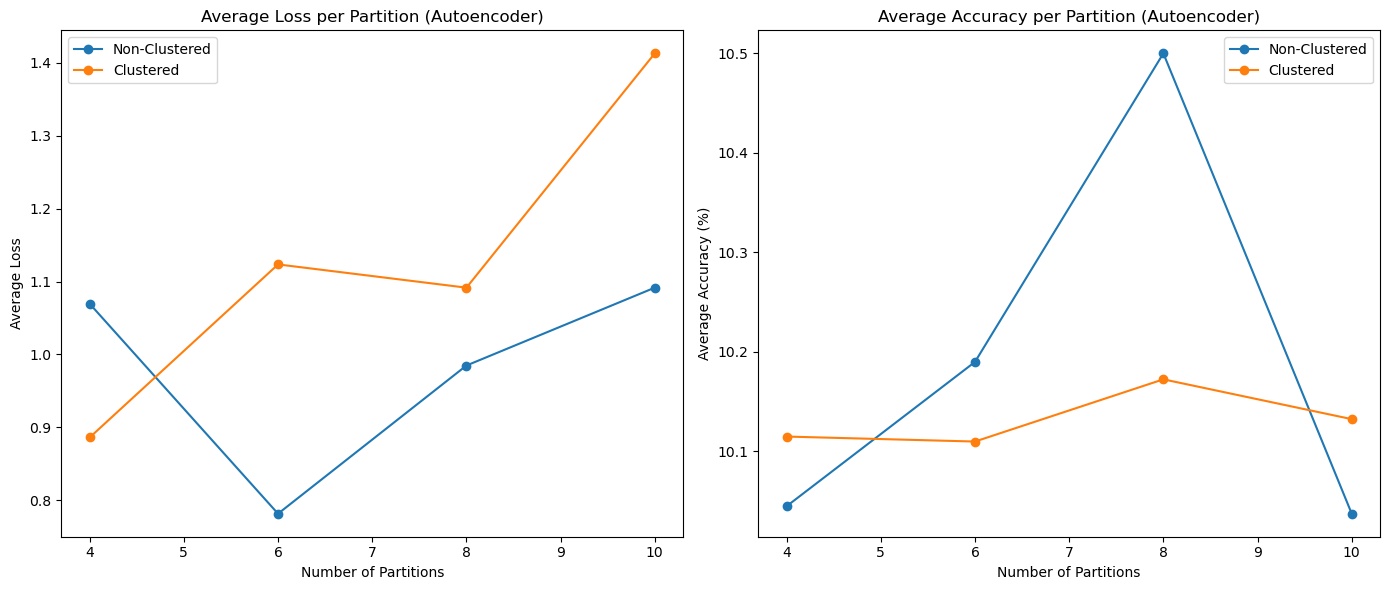

In [120]:
import matplotlib.pyplot as plt

def calculate_client_averages(data):
    client_averages = {}
    for client, client_data in data.items():  
        client_averages[client] = {}
        for partition_number, metrics in client_data.items():  # Iterate over partitions
            avg_loss = sum(metrics['losses']) / len(metrics['losses']) if metrics['losses'] else 0
            avg_accuracy = sum(metrics['accuracy']) / len(metrics['accuracy']) if metrics['accuracy'] else 0
            client_averages[client][partition_number] = {"average_loss": avg_loss, "average_accuracy": avg_accuracy}
    return client_averages


non_clustered_averages = calculate_client_averages(results)
clustered_averages = calculate_client_averages(clusteredResults)


def plot_averages(non_clustered, clustered):
    for client_type in non_clustered.keys(): 
        partitions_non_clustered = list(non_clustered[client_type].keys())
        losses_non_clustered = [
            non_clustered[client_type][partition]["average_loss"] for partition in partitions_non_clustered
        ]
        accuracies_non_clustered = [
            non_clustered[client_type][partition]["average_accuracy"] for partition in partitions_non_clustered
        ]

        partitions_clustered = list(clustered[client_type].keys())
        losses_clustered = [
            clustered[client_type][partition]["average_loss"] for partition in partitions_clustered
        ]
        accuracies_clustered = [
            clustered[client_type][partition]["average_accuracy"] for partition in partitions_clustered
        ]

        plt.figure(figsize=(14, 6))

 
        plt.subplot(1, 2, 1)
        plt.plot(partitions_non_clustered, losses_non_clustered, label="Non-Clustered", marker="o")
        plt.plot(partitions_clustered, losses_clustered, label="Clustered", marker="o")
        plt.xlabel("Number of Partitions")
        plt.ylabel("Average Loss")
        plt.title(f"Average Loss per Partition ({client_type.capitalize()})")
        plt.legend()

 
        plt.subplot(1, 2, 2)
        plt.plot(partitions_non_clustered, accuracies_non_clustered, label="Non-Clustered", marker="o")
        plt.plot(partitions_clustered, accuracies_clustered, label="Clustered", marker="o")
        plt.xlabel("Number of Partitions")
        plt.ylabel("Average Accuracy (%)")
        plt.title(f"Average Accuracy per Partition ({client_type.capitalize()})")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot averages for all client types
plot_averages(non_clustered_averages, clustered_averages)